# Validate the MCMC Log-Prob Fix
# Can SCITE find the ideal tree under easy conditions

Looking at the results of MARK02, I still have trust issues with the results. The true tree does not seem to be found all the time for small trees. Why?

This needs some manual investigation.

In [35]:
## imports
import pyggdrasil as yg
import jax.numpy as jnp
import jax.random as random
from pathlib import Path
import matplotlib.pyplot as plt

# matplotlib inline
%matplotlib inline 
import matplotlib
matplotlib.use('MacOSX')

In [9]:
# make true tree
tree_type = yg.tree_inference.TreeType.RANDOM
mutations = 4
nodes = mutations + 1
tree_seed = 42
true_tree = yg.tree_inference.make_tree(nodes, tree_type, tree_seed) 

true_tree.print_topo()

4
├── 0
├── 2
│   └── 1
└── 3


In [25]:
## generate some little nois data
# Set up the simulation model
csm = yg.tree_inference.CellSimulationModel(
    n_cells=1000,
    n_mutations=mutations,
    fpr=0.01,
    fnr=0.01,
    na_rate=0.0,
    observe_homozygous=False,
    strategy=yg.tree_inference.CellAttachmentStrategy.UNIFORM_EXCLUDE_ROOT,
)


# Generate Data
seed = 42
rng = random.PRNGKey(seed)
data = yg.tree_inference.gen_sim_data(
    csm,
    rng,
    true_tree
    )

mut_mat = jnp.array(data['noisy_mutation_mat'])
print(mut_mat)

[[0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 1 1 0]]


In [30]:
## Run MCMC

init_tree_t = yg.tree_inference.Tree.tree_from_tree_node(true_tree)

save_dir = Path("../data.nosync/notebooks/")
# make directory if it doesn't exist
save_dir.mkdir(parents=True, exist_ok=True)
save_name = "mcmc_test"
full_save_name = save_dir / f"{save_name}.json"
# make file if it doesn't exist
full_save_name.touch(exist_ok=True)

move_probs = yg.tree_inference.MoveProbabilities()
error_rates = yg.tree_inference.ErrorCombinations.IDEAL.value

# run mcmc sampler
yg.tree_inference.mcmc_sampler(
    rng_key=rng,
    data=mut_mat,
    error_rates=(error_rates.fpr, error_rates.fnr),
    move_probs=move_probs,
    num_samples=1000,
    num_burn_in=0,
    out_fp=full_save_name,
    thinning=1,
    init_tree=init_tree_t,
)

# load the data
mcmc_data = yg.serialize.read_mcmc_samples(save_dir / f"{save_name}.json")

print(mcmc_data.__len__())

INFO:pyggdrasil.tree_inference._mcmc_sampler:Starting MCMC sampler.


INFO:pyggdrasil.tree_inference._mcmc_sampler:Starting MCMC loop.
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Accepted
INFO:pyggdrasil.tree_inference._mcmc:Move Accepted
INFO:pyggdrasil.tree_inference._mcmc:Move Accepted
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.tree_inference._mcmc:Move Rejected
INFO:pyggdrasil.t

1000


In [36]:
# Visualize the results
# How is the trace of the log probability?

# unpack the data - reads in the serialized trees to Tree objects
mcmc_samples = yg.analyze.to_pure_mcmc_data(mcmc_data)

DEBUG:pyggdrasil.analyze._utils:converting sample of index: 0
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 1
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 2
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 3
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 4
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 5
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 6
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 7
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 8
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 9
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 10
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 11
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 12
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 13
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 14
DEBUG:pyggdrasil.analyze._utils:converting sample of index: 15
DE

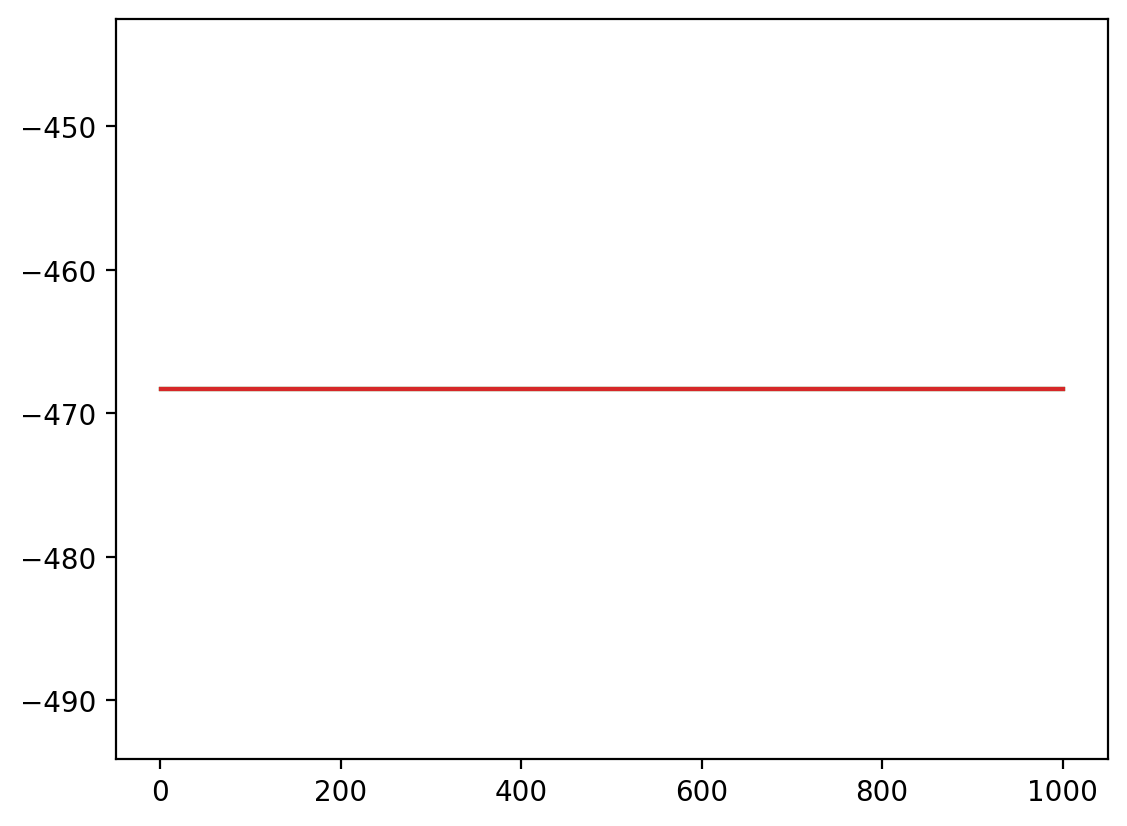

In [45]:
# plot the log probability
matplotlib.use('MacOSX')
%matplotlib inline
plt.plot(mcmc_samples.iterations, mcmc_samples.log_probabilities)
plt.show()

In [47]:
# hwo many values of the log probability are there?
print(mcmc_samples.log_probabilities.__len__())
# how many unique values of the log probability are there?
print(jnp.unique(mcmc_samples.log_probabilities).__len__())

1000
1
